## Autonomous SLAM System for UAVs with 3 axis

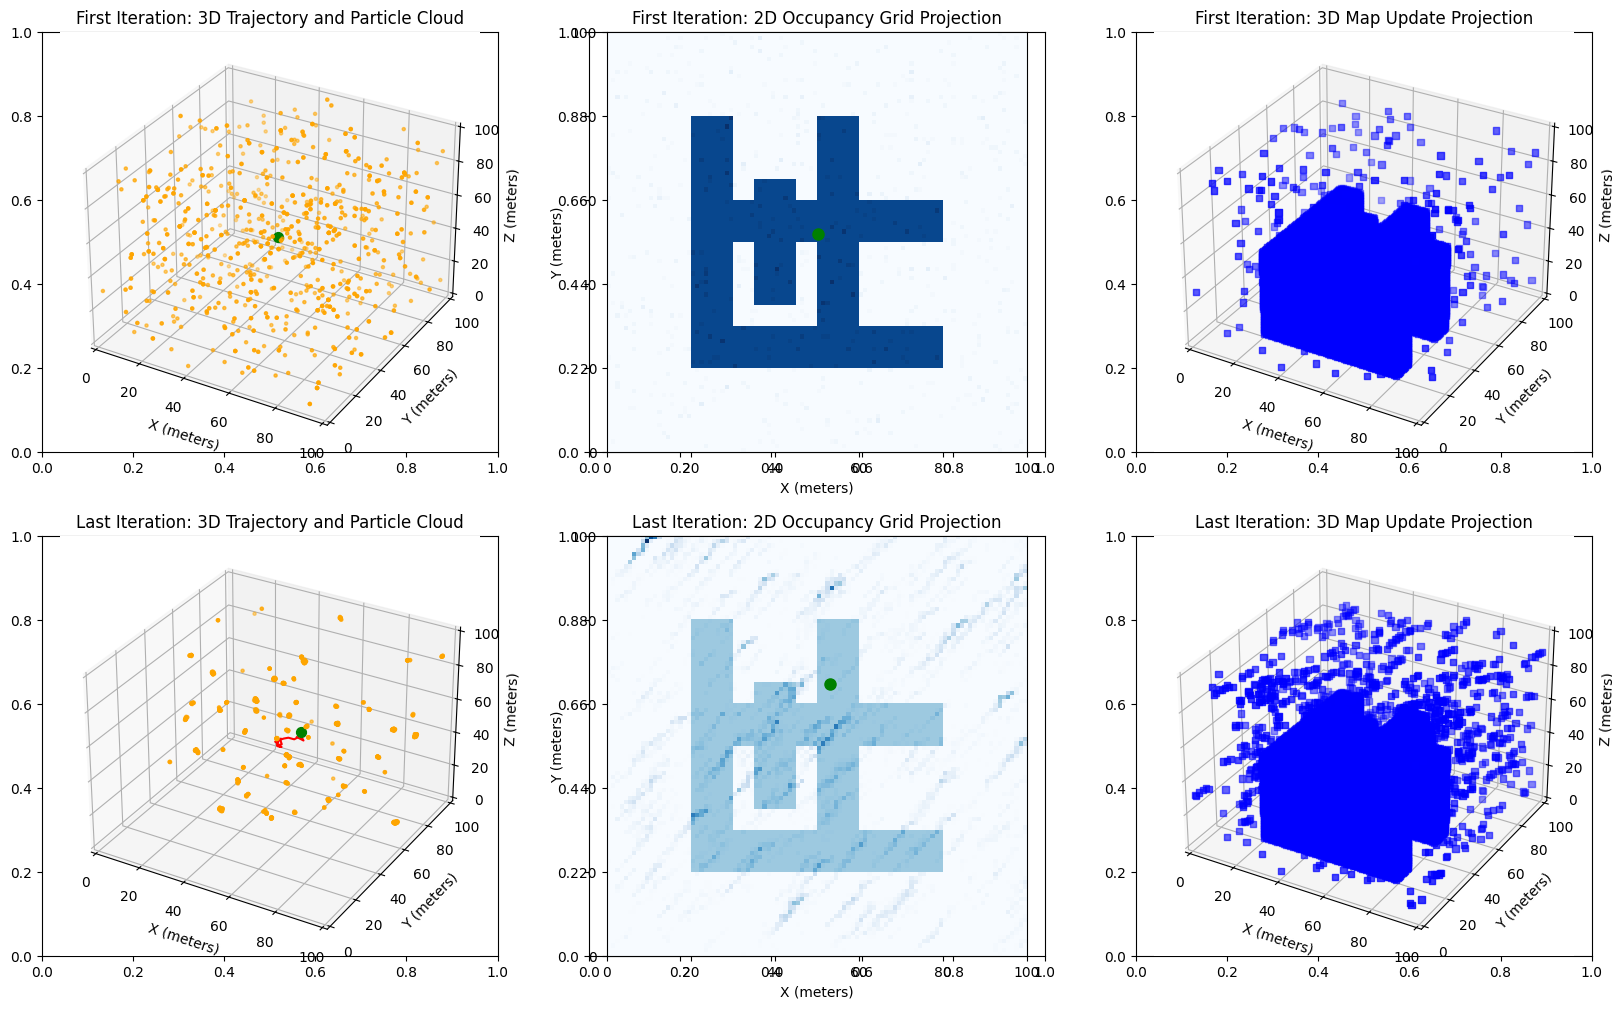

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm

NUM_PARTICLES = 1000
MAP_SIZE = 100
GRID_RESOLUTION = 1
NOISE_STD = 0.1

# Initialize the map (occupancy grid) with a labyrinth
def initialize_map(size, resolution):
    map = np.zeros((size // resolution, size // resolution, size // resolution))
    # Add a labyrinth-like structure to an empty space
    map[20:30, 20:80, 0:50] = 1
    map[50:60, 20:80, 0:50] = 1
    map[20:80, 20:30, 0:50] = 1
    map[20:80, 50:60, 0:50] = 1
    map[35:45, 35:65, 0:50] = 1
    return map

# Initialize particles
def initialize_particles(num_particles, map_size):
    particles = np.random.rand(num_particles, 3) * map_size
    weights = np.ones(num_particles) / num_particles
    return particles, weights

# Motion model: Update particle positions based on control input
def motion_model(particles, control, noise_std):
    noise = np.random.normal(0, noise_std, particles.shape)
    particles += control + noise
    return particles

# Sensor model: Update particle weights based on sensor measurements
def sensor_model(particles, measurements, map, resolution, noise_std):
    weights = np.zeros(len(particles))
    for i, particle in enumerate(particles):
        x, y, z = particle
        grid_x, grid_y, grid_z = int(x // resolution), int(y // resolution), int(z // resolution)
        if 0 <= grid_x < map.shape[0] and 0 <= grid_y < map.shape[1] and 0 <= grid_z < map.shape[2]:
            # Simulate sensor reading (e.g., distance to nearest obstacle)
            expected_measurement = map[grid_x, grid_y, grid_z]
            # Compute likelihood for each particle's measurement
            weights[i] = norm.pdf(measurements[i], expected_measurement, noise_std)
    weights /= np.sum(weights)  # Normalize weights
    return weights

# Resample particles based on weights
def resample_particles(particles, weights):
    indices = np.random.choice(np.arange(len(particles)), size=len(particles), p=weights)
    return particles[indices], np.ones(len(particles)) / len(particles)

# Update occupancy grid based on particle positions
def update_map(map, particles, resolution):
    for particle in particles:
        x, y, z = particle
        grid_x, grid_y, grid_z = int(x // resolution), int(y // resolution), int(z // resolution)
        if 0 <= grid_x < map.shape[0] and 0 <= grid_y < map.shape[1] and 0 <= grid_z < map.shape[2]:
            map[grid_x, grid_y, grid_z] += 1
    return map

# Simulate sensor measurements
def simulate_sensor_measurements(particles, map, resolution, noise_std):
    measurements = np.zeros(len(particles))
    for i, particle in enumerate(particles):
        x, y, z = particle
        grid_x, grid_y, grid_z = int(x // resolution), int(y // resolution), int(z // resolution)
        if 0 <= grid_x < map.shape[0] and 0 <= grid_y < map.shape[1] and 0 <= grid_z < map.shape[2]:
            # Simulate sensor  - distance to nearest obstacle
            measurement = map[grid_x, grid_y, grid_z] + np.random.normal(0, noise_std)
            measurements[i] = measurement
        else:
            # If particle is outside the map, assign a default measurement 0
            measurements[i] = 0
    return measurements

# Main SLAM loop
def slam(num_iterations, control_inputs):
    map = initialize_map(MAP_SIZE, GRID_RESOLUTION)
    particles, weights = initialize_particles(NUM_PARTICLES, MAP_SIZE)

    # Visualization setup with 3 plots for first and last iterations
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 3D Trajectory Plot for First Iteration
    ax1_first = fig.add_subplot(231, projection='3d')
    ax1_first.set_xlim(0, MAP_SIZE)
    ax1_first.set_ylim(0, MAP_SIZE)
    ax1_first.set_zlim(0, MAP_SIZE)
    ax1_first.set_xlabel('X (meters)')
    ax1_first.set_ylabel('Y (meters)')
    ax1_first.set_zlabel('Z (meters)')
    ax1_first.set_title('First Iteration: 3D Trajectory and Particle Cloud')

    # 2D Occupancy Map Projection for First Iteration
    ax2_first = fig.add_subplot(232)
    ax2_first.set_xlim(0, MAP_SIZE)
    ax2_first.set_ylim(0, MAP_SIZE)
    ax2_first.set_xlabel('X (meters)')
    ax2_first.set_ylabel('Y (meters)')
    ax2_first.set_title('First Iteration: 2D Occupancy Grid Projection')

    # 3D Map Update Projection for First Iteration
    ax3_first = fig.add_subplot(233, projection='3d')
    ax3_first.set_xlim(0, MAP_SIZE)
    ax3_first.set_ylim(0, MAP_SIZE)
    ax3_first.set_zlim(0, MAP_SIZE)
    ax3_first.set_xlabel('X (meters)')
    ax3_first.set_ylabel('Y (meters)')
    ax3_first.set_zlabel('Z (meters)')
    ax3_first.set_title('First Iteration: 3D Map Update Projection')

    # 3D Trajectory Plot for Last Iteration
    ax1_last = fig.add_subplot(234, projection='3d')
    ax1_last.set_xlim(0, MAP_SIZE)
    ax1_last.set_ylim(0, MAP_SIZE)
    ax1_last.set_zlim(0, MAP_SIZE)
    ax1_last.set_xlabel('X (meters)')
    ax1_last.set_ylabel('Y (meters)')
    ax1_last.set_zlabel('Z (meters)')
    ax1_last.set_title('Last Iteration: 3D Trajectory and Particle Cloud')

    # 2D Occupancy Map Projection for Last Iteration
    ax2_last = fig.add_subplot(235)
    ax2_last.set_xlim(0, MAP_SIZE)
    ax2_last.set_ylim(0, MAP_SIZE)
    ax2_last.set_xlabel('X (meters)')
    ax2_last.set_ylabel('Y (meters)')
    ax2_last.set_title('Last Iteration: 2D Occupancy Grid Projection')

    # 3D Map Update Projection for Last Iteration
    ax3_last = fig.add_subplot(236, projection='3d')
    ax3_last.set_xlim(0, MAP_SIZE)
    ax3_last.set_ylim(0, MAP_SIZE)
    ax3_last.set_zlim(0, MAP_SIZE)
    ax3_last.set_xlabel('X (meters)')
    ax3_last.set_ylabel('Y (meters)')
    ax3_last.set_zlabel('Z (meters)')
    ax3_last.set_title('Last Iteration: 3D Map Update Projection')

    # Store trajectory and other data
    trajectory = []

    # First iteration visualization
    particles = motion_model(particles, control_inputs[0], NOISE_STD)
    measurements = simulate_sensor_measurements(particles, map, GRID_RESOLUTION, NOISE_STD)
    weights = sensor_model(particles, measurements, map, GRID_RESOLUTION, NOISE_STD)
    particles, weights = resample_particles(particles, weights)
    map = update_map(map, particles, GRID_RESOLUTION)
    trajectory.append(np.mean(particles, axis=0))

    # Visualize first iteration
    x, y, z = np.where(map == 1)
    ax1_first.scatter(particles[:, 0], particles[:, 1], particles[:, 2], c='orange', s=5, label='Particles')
    ax1_first.plot([t[0] for t in trajectory], [t[1] for t in trajectory], [t[2] for t in trajectory], c='r', label='Trajectory')
    ax1_first.scatter(trajectory[-1][0], trajectory[-1][1], trajectory[-1][2], c='g', s=50, label='Quadcopter Position')

    ax2_first.imshow(np.sum(map, axis=2).T, origin='lower', cmap='Blues', extent=[0, MAP_SIZE, 0, MAP_SIZE])
    ax2_first.plot(trajectory[-1][0], trajectory[-1][1], 'go', markersize=8)  # Quadcopter position

    ax3_first.scatter(x, y, z, c='blue', marker='s', label='Walls (Obstacles)')

    # Run the rest of the iterations
    for iteration in range(1, num_iterations):
        particles = motion_model(particles, control_inputs[iteration], NOISE_STD)
        measurements = simulate_sensor_measurements(particles, map, GRID_RESOLUTION, NOISE_STD)
        weights = sensor_model(particles, measurements, map, GRID_RESOLUTION, NOISE_STD)
        particles, weights = resample_particles(particles, weights)
        map = update_map(map, particles, GRID_RESOLUTION)
        trajectory.append(np.mean(particles, axis=0))

    # Visualize last iteration
    x, y, z = np.where(map == 1)
    ax1_last.scatter(particles[:, 0], particles[:, 1], particles[:, 2], c='orange', s=5, label='Particles')
    ax1_last.plot([t[0] for t in trajectory], [t[1] for t in trajectory], [t[2] for t in trajectory], c='r', label='Trajectory')
    ax1_last.scatter(trajectory[-1][0], trajectory[-1][1], trajectory[-1][2], c='g', s=50, label='Quadcopter Position')

    ax2_last.imshow(np.sum(map, axis=2).T, origin='lower', cmap='Blues', extent=[0, MAP_SIZE, 0, MAP_SIZE])
    ax2_last.plot(trajectory[-1][0], trajectory[-1][1], 'go', markersize=8)

    ax3_last.scatter(x, y, z, c='blue', marker='s', label='Walls (Obstacles)')

    plt.show()

# Example control inputs (simulated)
control_inputs = [np.random.rand(3) for _ in range(20)]

# Run SLAM
slam(20, control_inputs)

##Unit Tests



In [ ]:
import unittest

# Тесты
class TestSlamFunctions(unittest.TestCase):

    def test_initialize_map(self):
        """Test the initialization of the occupancy grid."""
        map = initialize_map(MAP_SIZE, GRID_RESOLUTION)
        self.assertEqual(map.shape, (MAP_SIZE // GRID_RESOLUTION, MAP_SIZE // GRID_RESOLUTION, MAP_SIZE // GRID_RESOLUTION))
        self.assertTrue(np.any(map == 1))  # Ensure the labyrinth structure is present
        print("test_initialize_map: PASSED")

    def test_initialize_particles(self):
        """Test the initialization of particles."""
        particles, weights = initialize_particles(NUM_PARTICLES, MAP_SIZE)
        self.assertEqual(particles.shape, (NUM_PARTICLES, 3))
        self.assertEqual(weights.shape, (NUM_PARTICLES,))
        self.assertTrue(np.all(weights == 1.0 / NUM_PARTICLES))  # All weights should sum to 1
        print("test_initialize_particles: PASSED")

    def test_sensor_model(self):
        """Test the sensor model."""
        particles, _ = initialize_particles(NUM_PARTICLES, MAP_SIZE)
        map = initialize_map(MAP_SIZE, GRID_RESOLUTION)
        measurements = simulate_sensor_measurements(particles, map, GRID_RESOLUTION, NOISE_STD)
        weights = sensor_model(particles, measurements, map, GRID_RESOLUTION, NOISE_STD)
        self.assertEqual(weights.shape, (NUM_PARTICLES,))
        self.assertTrue(np.all(weights >= 0))  # Weights should be non-negative
        self.assertAlmostEqual(np.sum(weights), 1.0, delta=1e-6)  # Weights should sum to 1
        print("test_sensor_model: PASSED")

    def test_resample_particles(self):
        """Test particle resampling."""
        particles, weights = initialize_particles(NUM_PARTICLES, MAP_SIZE)
        resampled_particles, resampled_weights = resample_particles(particles, weights)
        self.assertEqual(resampled_particles.shape, particles.shape)
        self.assertTrue(np.all(resampled_weights == 1.0 / NUM_PARTICLES))  # Resampled weights should sum to 1
        print("test_resample_particles: PASSED")

    def test_update_map(self):
        """Test the update of the occupancy grid."""
        map = initialize_map(MAP_SIZE, GRID_RESOLUTION)
        particles, _ = initialize_particles(NUM_PARTICLES, MAP_SIZE)
        updated_map = update_map(map, particles, GRID_RESOLUTION)
        self.assertEqual(updated_map.shape, map.shape)
        self.assertTrue(np.any(updated_map > 0))  # Map should have updated values
        print("test_update_map: PASSED")

    def test_simulate_sensor_measurements(self):
        """Test the simulation of sensor measurements."""
        particles, _ = initialize_particles(NUM_PARTICLES, MAP_SIZE)
        map = initialize_map(MAP_SIZE, GRID_RESOLUTION)
        measurements = simulate_sensor_measurements(particles, map, GRID_RESOLUTION, NOISE_STD)
        self.assertEqual(measurements.shape, (NUM_PARTICLES,))
        self.assertTrue(np.any(measurements > 0))  # Measurements should be non-zero
        print("test_simulate_sensor_measurements: PASSED")

# Запуск тестов
if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

......
----------------------------------------------------------------------
Ran 6 tests in 0.199s

OK


test_initialize_map: PASSED
test_initialize_particles: PASSED
test_resample_particles: PASSED
test_sensor_model: PASSED
test_simulate_sensor_measurements: PASSED
test_update_map: PASSED


##SLAM with real data from rgbd_dataset (https://cvg.cit.tum.de/data/datasets/rgbd-dataset/download)

In [47]:
# Укажите путь к папке с датасетом
dataset_path = "/content/drive/MyDrive/data"
rgb_folder = f"{dataset_path}/rgb"
depth_folder = f"{dataset_path}/depth"
groundtruth_file = f"{dataset_path}/groundtruth.txt"

import os

# Загрузка списка файлов из папок rgb и depth
def load_dataset_files(rgb_folder, depth_folder):
    # Получаем список файлов в папке rgb
    rgb_files = sorted(os.listdir(rgb_folder))
    # Получаем список файлов в папке depth
    depth_files = sorted(os.listdir(depth_folder))

    # Проверяем, что количество файлов совпадает
    if len(rgb_files) != len(depth_files):
        raise ValueError("Количество RGB-изображений и карт глубины не совпадает!")

    # Создаем список пар (rgb_path, depth_path)
    dataset = []
    for rgb_file, depth_file in zip(rgb_files, depth_files):
        rgb_path = os.path.join(rgb_folder, rgb_file)
        depth_path = os.path.join(depth_folder, depth_file)
        dataset.append((rgb_path, depth_path))

    return dataset

# Пример использования
dataset = load_dataset_files(rgb_folder, depth_folder)
print("Первые 5 пар файлов:")
for rgb_path, depth_path in dataset[:5]:
    print(f"RGB: {rgb_path}, Depth: {depth_path}")

Первые 5 пар файлов:
RGB: /content/drive/MyDrive/data/rgb/1305031102.175304.png, Depth: /content/drive/MyDrive/data/depth/1305031102.160407.png
RGB: /content/drive/MyDrive/data/rgb/1305031102.211214.png, Depth: /content/drive/MyDrive/data/depth/1305031102.194330.png
RGB: /content/drive/MyDrive/data/rgb/1305031102.243211.png, Depth: /content/drive/MyDrive/data/depth/1305031102.226738.png
RGB: /content/drive/MyDrive/data/rgb/1305031102.275326.png, Depth: /content/drive/MyDrive/data/depth/1305031102.262886.png
RGB: /content/drive/MyDrive/data/rgb/1305031102.311267.png, Depth: /content/drive/MyDrive/data/depth/1305031102.295279.png


<ipython-input-46-7bc872841df1>:45: RuntimeWarning: invalid value encountered in divide
  weights /= np.sum(weights)  # Normalize weights


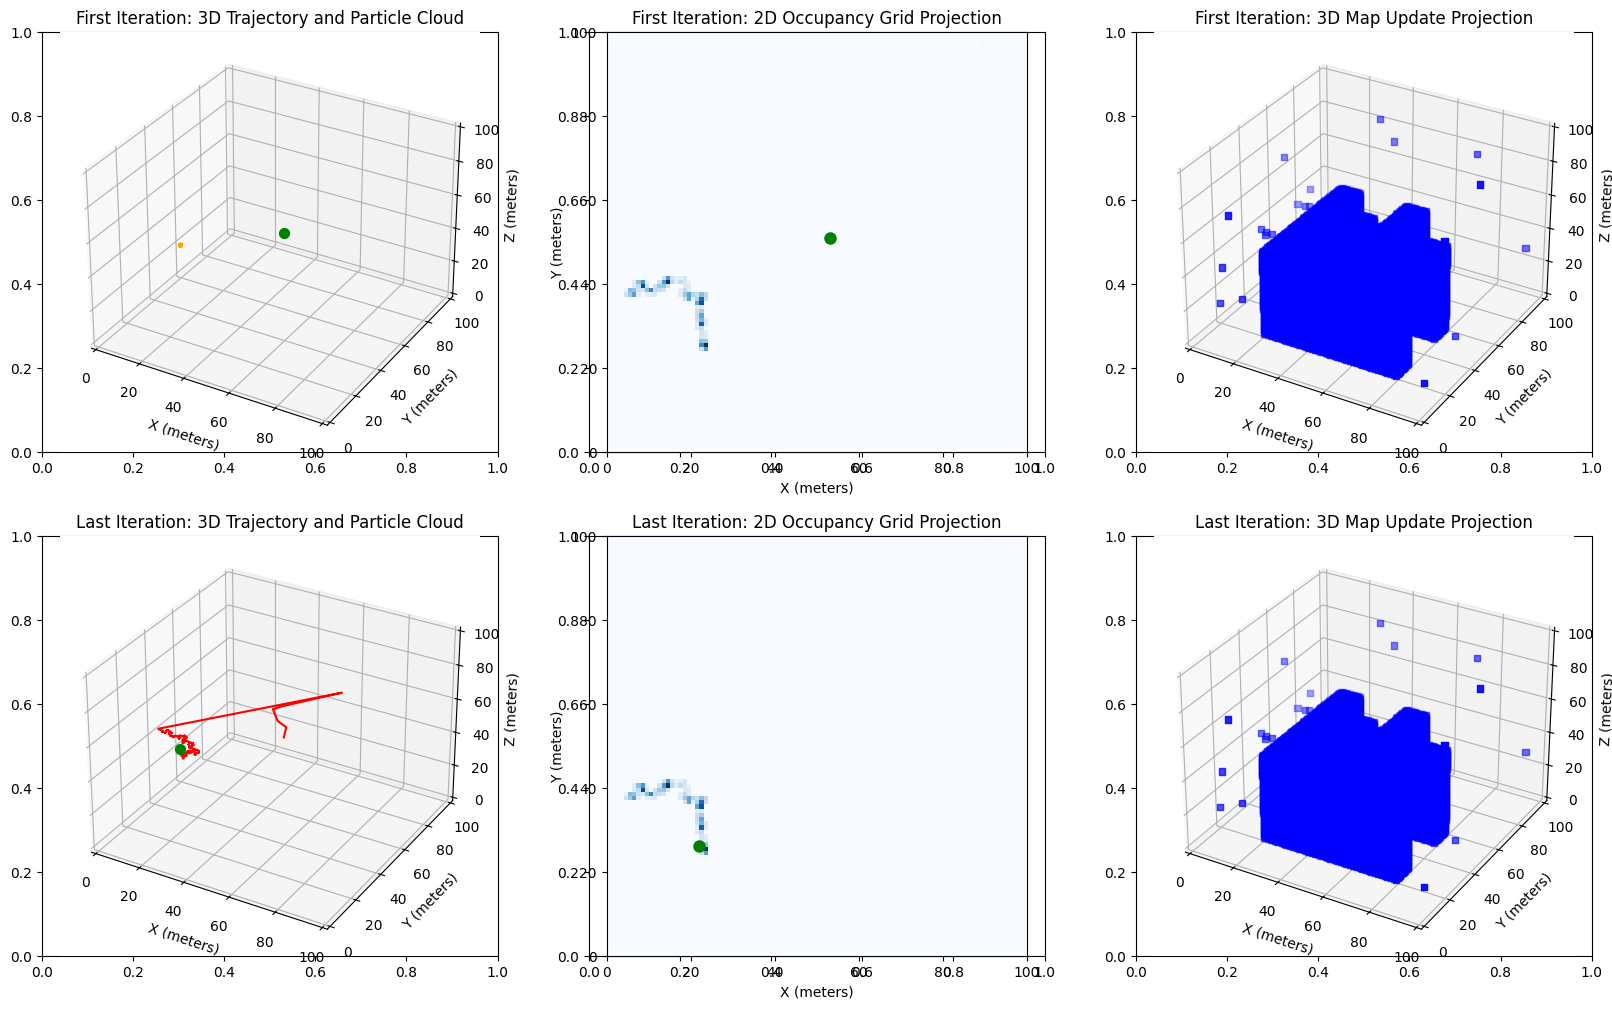

In [51]:
# Load the dataset
dataset = load_dataset_files(rgb_folder, depth_folder)

# Load ground truth poses
groundtruth_poses = []
with open(groundtruth_file, 'r') as f:
    for line in f:
        if line.startswith('#'):
          continue
        x, y, z = __builtins__.map(float, line.strip().split()[:3])
        groundtruth_poses.append(np.array([x, y, z]))

# Main SLAM loop with real data
def slam_with_real_data(dataset, groundtruth_poses):
    map = initialize_map(MAP_SIZE, GRID_RESOLUTION)
    particles, weights = initialize_particles(NUM_PARTICLES, MAP_SIZE)

    # Visualization setuz
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 3D Trajectory Plot for First Iteration
    ax1_first = fig.add_subplot(231, projection='3d')
    ax1_first.set_xlim(0, MAP_SIZE)
    ax1_first.set_ylim(0, MAP_SIZE)
    ax1_first.set_zlim(0, MAP_SIZE)
    ax1_first.set_xlabel('X (meters)')
    ax1_first.set_ylabel('Y (meters)')
    ax1_first.set_zlabel('Z (meters)')
    ax1_first.set_title('First Iteration: 3D Trajectory and Particle Cloud')

    # 2D Occupancy Map Projection for First Iteration
    ax2_first = fig.add_subplot(232)
    ax2_first.set_xlim(0, MAP_SIZE)
    ax2_first.set_ylim(0, MAP_SIZE)
    ax2_first.set_xlabel('X (meters)')
    ax2_first.set_ylabel('Y (meters)')
    ax2_first.set_title('First Iteration: 2D Occupancy Grid Projection')

    # 3D Map Update Projection for First Iteration
    ax3_first = fig.add_subplot(233, projection='3d')
    ax3_first.set_xlim(0, MAP_SIZE)
    ax3_first.set_ylim(0, MAP_SIZE)
    ax3_first.set_zlim(0, MAP_SIZE)
    ax3_first.set_xlabel('X (meters)')
    ax3_first.set_ylabel('Y (meters)')
    ax3_first.set_zlabel('Z (meters)')
    ax3_first.set_title('First Iteration: 3D Map Update Projection')

    # 3D Trajectory Plot for Last Iteration
    ax1_last = fig.add_subplot(234, projection='3d')
    ax1_last.set_xlim(0, MAP_SIZE)
    ax1_last.set_ylim(0, MAP_SIZE)
    ax1_last.set_zlim(0, MAP_SIZE)
    ax1_last.set_xlabel('X (meters)')
    ax1_last.set_ylabel('Y (meters)')
    ax1_last.set_zlabel('Z (meters)')
    ax1_last.set_title('Last Iteration: 3D Trajectory and Particle Cloud')

    # 2D Occupancy Map Projection for Last Iteration
    ax2_last = fig.add_subplot(235)
    ax2_last.set_xlim(0, MAP_SIZE)
    ax2_last.set_ylim(0, MAP_SIZE)
    ax2_last.set_xlabel('X (meters)')
    ax2_last.set_ylabel('Y (meters)')
    ax2_last.set_title('Last Iteration: 2D Occupancy Grid Projection')

    # 3D Map Update Projection for Last Iteration
    ax3_last = fig.add_subplot(236, projection='3d')
    ax3_last.set_xlim(0, MAP_SIZE)
    ax3_last.set_ylim(0, MAP_SIZE)
    ax3_last.set_zlim(0, MAP_SIZE)
    ax3_last.set_xlabel('X (meters)')
    ax3_last.set_ylabel('Y (meters)')
    ax3_last.set_zlabel('Z (meters)')
    ax3_last.set_title('Last Iteration: 3D Map Update Projection')

    trajectory = []

    # First iteration visualization
    for i, (rgb_path, depth_path) in enumerate(dataset):
        depth_image = np.array(Image.open(depth_path))
        measurements = np.random.choice(depth_image.flatten(), size=NUM_PARTICLES)
        measurements = measurements.astype(np.float64)
        measurements += np.random.normal(0, NOISE_STD, measurements.shape)
        control = groundtruth_poses[i] - groundtruth_poses[i - 1] if i > 0 else np.zeros(3)
        particles = motion_model(particles, control, NOISE_STD)
        weights = sensor_model(particles, measurements, map, GRID_RESOLUTION, NOISE_STD)
        particles, weights = resample_particles(particles, weights)
        map = update_map(map, particles, GRID_RESOLUTION)
        trajectory.append(np.mean(particles, axis=0))

    # Visualize first and last iterations
    x, y, z = np.where(map == 1)
    ax1_first.scatter(particles[:, 0], particles[:, 1], particles[:, 2], c='orange', s=5, label='Particles')
    ax1_first.scatter(trajectory[0][0], trajectory[0][1], trajectory[0][2], c='g', s=50, label='Quadcopter Position')

    ax2_first.imshow(np.sum(map, axis=2).T, origin='lower', cmap='Blues', extent=[0, MAP_SIZE, 0, MAP_SIZE])
    ax2_first.plot(trajectory[0][0], trajectory[0][1], 'go', markersize=8)

    ax3_first.scatter(x, y, z, c='blue', marker='s', label='Walls (Obstacles)')

    ax1_last.scatter(particles[:, 0], particles[:, 1], particles[:, 2], c='orange', s=5, label='Particles')
    ax1_last.plot([t[0] for t in trajectory], [t[1] for t in trajectory], [t[2] for t in trajectory], c='r', label='Trajectory')
    ax1_last.scatter(trajectory[-1][0], trajectory[-1][1], trajectory[-1][2], c='g', s=50, label='Quadcopter Position')

    ax2_last.imshow(np.sum(map, axis=2).T, origin='lower', cmap='Blues', extent=[0, MAP_SIZE, 0, MAP_SIZE])
    ax2_last.plot(trajectory[-1][0], trajectory[-1][1], 'go', markersize=8)

    ax3_last.scatter(x, y, z, c='blue', marker='s', label='Walls (Obstacles)')

    plt.show()

# Resample particles based on weights
def resample_particles(particles, weights):
    if np.any(np.isnan(weights)) or np.all(weights == 0):
        weights = np.ones(len(particles)) / len(particles)
    else:
        weights /= np.sum(weights)
    indices = np.random.choice(np.arange(len(particles)), size=len(particles), p=weights)
    return particles[indices], np.ones(len(particles)) / len(particles)

# Run SLAM with real data
slam_with_real_data(dataset, groundtruth_poses)